In [64]:
import torch

noise = torch.randn(1,1,SinGAN.lr_h, SinGAN.lr_w).to(SinGAN.device)
lr = SinGAN.G_ema(noise)
fold_params = {'kernel_size': 7, 'padding': 3, 'stride': 1, 'dilation': 1}
divisor = functions.getDivisor(lr, fold_params)
print()
origin_dis = nn.functional.unfold(SinGAN.lr_image, **fold_params)[...,::2]
lr_dis = nn.functional.unfold(lr, **fold_params)[...,::2]
num = lr_dis.shape[-1]
lr_pm, A = SinGAN.lpm(lr, SinGAN.lr_image, fold_params = fold_params, divisor = divisor, n = 1,
                                  hard = True)
lr_pm_dis = nn.functional.unfold(lr_pm, **fold_params)[...,::2]

data1 = torch.cat([origin_dis, lr_dis, lr_pm_dis], dim = -1)

data1 = data.squeeze(0).permute(1,0).cpu().detach().numpy()

from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(data)
    

(1071, 2)


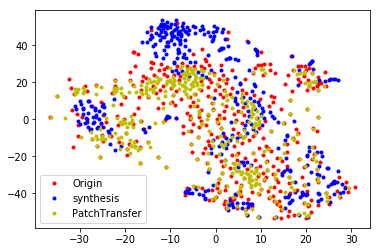

In [69]:
import matplotlib.pyplot as plt
print(X_embedded.shape)
plt.plot(X_embedded[:num, 0],X_embedded[:num, 1],'r.', label = 'Origin')
plt.plot(X_embedded[num: 2*num, 0],X_embedded[num: 2*num, 1],'b.', label = 'synthesis')
plt.plot(X_embedded[2*num:,0],X_embedded[2*num:,1],'y.', label = 'PatchTransfer')
plt.legend()

In [71]:
hr = SinGAN.recnet(lr)

fold_params = {'kernel_size': 7, 'padding': 3, 'stride': 2, 'dilation': 1}
divisor = functions.getDivisor(hr, fold_params)

origin_hr_dis = nn.functional.unfold(SinGAN.hr_image, **fold_params)[...,::1]
hr_dis = nn.functional.unfold(hr, **fold_params)[...,::1]
num = hr_dis.shape[-1]

hr_pm = SinGAN.recnet(lr_pm)
hr_pm_dis = nn.functional.unfold(hr_pm, **fold_params)[...,::1]

data2 = torch.cat([origin_hr_dis, hr_dis, hr_pm_dis], dim = -1)

data2 = data2.squeeze(0).permute(1,0).cpu().detach().numpy()

from sklearn.manifold import TSNE
Y_embedded = TSNE(n_components=2).fit_transform(data2)


KeyboardInterrupt: 

In [72]:
import cuml

ModuleNotFoundError: No module named 'cuml'

In [78]:
#
#  tsne_torch.py
#
# Implementation of t-SNE in pytorch. The implementation was tested on pytorch
# > 1.0, and it requires Numpy to read files. In order to plot the results,
# a working installation of matplotlib is required.
#
#
# The example can be run by executing: `python tsne_torch.py`
#
#
#  Created by Xiao Li on 23-03-2020.
#  Copyright (c) 2020. All rights reserved.
import numpy as np
import matplotlib.pyplot as pyplot
import argparse
import torch

parser = argparse.ArgumentParser()
parser.add_argument("--xfile", type=str, default="mnist2500_X.txt", help="file name of feature stored")
parser.add_argument("--yfile", type=str, default="mnist2500_labels.txt", help="file name of label stored")
parser.add_argument("--cuda", type=int, default=1, help="if use cuda accelarate")

opt = parser.parse_args(args=['--xfile', "mnist2500_X.txt", '--yfile', "mnist2500_labels.txt",'--cuda',str(1)])
print("get choice from args", opt)
xfile = opt.xfile
yfile = opt.yfile

if opt.cuda:
    print("set use cuda")
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
else:
    torch.set_default_tensor_type(torch.DoubleTensor)


def Hbeta_torch(D, beta=1.0):
    P = torch.exp(-D.clone() * beta)

    sumP = torch.sum(P)

    H = torch.log(sumP) + beta * torch.sum(D * P) / sumP
    P = P / sumP

    return H, P


def x2p_torch(X, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape

    sum_X = torch.sum(X*X, 1)
    D = torch.add(torch.add(-2 * torch.mm(X, X.t()), sum_X).t(), sum_X)

    P = torch.zeros(n, n)
    beta = torch.ones(n, 1)
    logU = torch.log(torch.tensor([perplexity]))
    n_list = [i for i in range(n)]

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        # there may be something wrong with this setting None
        betamin = None
        betamax = None
        Di = D[i, n_list[0:i]+n_list[i+1:n]]

        (H, thisP) = Hbeta_torch(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while torch.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].clone()
                if betamax is None:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].clone()
                if betamin is None:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta_torch(Di, beta[i])

            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, n_list[0:i]+n_list[i+1:n]] = thisP

    # Return final P-matrix
    return P


def pca_torch(X, no_dims=50):
    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - torch.mean(X, 0)

    (l, M) = torch.eig(torch.mm(X.t(), X), True)
    # split M real
    for i in range(d):
        if l[i, 1] != 0:
            M[:, i+1] = M[:, i]
            i += 1

    Y = torch.mm(X, M[:, 0:no_dims])
    return Y


def tsne(X, no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should not have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca_torch(X, initial_dims)
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = torch.randn(n, no_dims)
    dY = torch.zeros(n, no_dims)
    iY = torch.zeros(n, no_dims)
    gains = torch.ones(n, no_dims)

    # Compute P-values
    P = x2p_torch(X, 1e-5, perplexity)
    P = P + P.t()
    P = P / torch.sum(P)
    P = P * 4.    # early exaggeration
    print("get P shape", P.shape)
    P = torch.max(P, torch.tensor([1e-21]))

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = torch.sum(Y*Y, 1)
        num = -2. * torch.mm(Y, Y.t())
        num = 1. / (1. + torch.add(torch.add(num, sum_Y).t(), sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / torch.sum(num)
        Q = torch.max(Q, torch.tensor([1e-12]))

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = torch.sum((PQ[:, i] * num[:, i]).repeat(no_dims, 1).t() * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)).double() + (gains * 0.8) * ((dY > 0.) == (iY > 0.)).double()
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - torch.mean(Y, 0)

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = torch.sum(P * torch.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y



hr = SinGAN.recnet(lr)

fold_params = {'kernel_size': 7, 'padding': 3, 'stride': 4, 'dilation': 1}
divisor = functions.getDivisor(hr, fold_params)

origin_hr_dis = nn.functional.unfold(SinGAN.hr_image, **fold_params)[...,::1]
hr_dis = nn.functional.unfold(hr, **fold_params)[...,::1]
num = hr_dis.shape[-1]

hr_pm = SinGAN.recnet(lr_pm)
hr_pm_dis = nn.functional.unfold(hr_pm, **fold_params)[...,::1]

data2 = torch.cat([origin_hr_dis, hr_dis, hr_pm_dis], dim = -1)

data2 = data2.squeeze(0).permute(1,0)


with torch.no_grad():
    Y = tsne(data2, 2, 50, 20.0)

if opt.cuda:
    Y = Y.cpu().numpy()


get choice from args Namespace(cuda=1, xfile='mnist2500_X.txt', yfile='mnist2500_labels.txt')
set use cuda
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 8556...
Computing P-values for point 500 of 8556...
Computing P-values for point 1000 of 8556...
Computing P-values for point 1500 of 8556...
Computing P-values for point 2000 of 8556...
Computing P-values for point 2500 of 8556...
Computing P-values for point 3000 of 8556...
Computing P-values for point 3500 of 8556...
Computing P-values for point 4000 of 8556...
Computing P-values for point 4500 of 8556...
Computing P-values for point 5000 of 8556...
Computing P-values for point 5500 of 8556...
Computing P-values for point 6000 of 8556...
Computing P-values for point 6500 of 8556...
Computing P-values for point 7000 of 8556...
Computing P-values for point 7500 of 8556...
Computing P-values for point 8000 of 8556...
Computing P-values for point 8500 of 8556...
get P shape torch.S

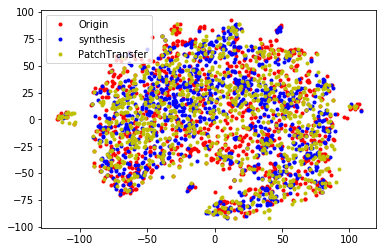

In [82]:
import matplotlib.pyplot as plt
skip = 3
plt.plot(Y[:num:skip, 0],Y[:num:skip, 1],'r.', label = 'Origin')
plt.plot(Y[num: 2*num:skip, 0],Y[num: 2*num:skip, 1],'b.', label = 'synthesis')
plt.plot(Y[2*num::skip,0],Y[2*num::skip,1],'y.', label = 'PatchTransfer')
plt.legend()

In [2]:
!nvidia-smi

Fri Aug 20 16:35:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:00:0C.0 Off |                    0 |
| N/A   33C    P0    50W / 250W |   1152MiB / 22919MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:00:0D.0 Off |                    0 |
| N/A   50C    P0   144W / 250W |   1957MiB / 22919MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T